<a href="https://colab.research.google.com/github/EkaterinaVoloshina/classification_of_dative_semantic_roles/blob/main/notebooks/supervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import log
import random
import os

import numpy as np
import pandas as pd
from pandas.core.algorithms import value_counts
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

le = LabelEncoder()
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 1. Препроцессинг данных

In [2]:
! git clone 'https://github.com/EkaterinaVoloshina/classification_of_dative_semantic_roles'

fatal: destination path 'classification_of_dative_semantic_roles' already exists and is not an empty directory.


In [3]:
df = pd.read_csv('./classification_of_dative_semantic_roles/data/unannotated_data.csv')
df = df.drop(['key', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df['prep'] = df['prep'].fillna(False).astype(int)
df['dobj'] = df['dobj'].fillna(False).astype(int)
df = df[df['role'] != 'none']
df[df['role'] == 'реципиент'] = df[df['role'] == 'реципиент'].iloc[:400]
df = df[df['d.lemma'].notnull()].fillna('none')
df.head()

,prep,dobj,d.lemma,d.pos,d.animacy,d.number,d.r,d.t,d.pt,d.top,d.d,v.lemma,v.pos,v.aspect,v.mood,v.r,v.ca,v.aux,v_d,s.lemma,s.pos,s.animacy,s.number,s.r,s.t,s.pt,s.top,s.d,role
70,0.0,0.0,себя,SPRO,none,SPRO,r:ref,none,none,none,none,завести,V,pf,imper,t:move,ca:caus,none,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,реципиент
195,0.0,1.0,себя,SPRO,none,SPRO,r:ref,none,none,none,none,взять,V,pf,indic,t:poss,ca:caus,none,none,кто,SPRO,none,sg,r:rel,none,none,none,none,реципиент
240,0.0,1.0,он,SPRO,none,norm,r:pers,none,none,none,none,возвращать,V,3p,sg,t:poss,none,none,d:pref,преемственность,S,nom,norm,r:abstr,none,none,none,der:a,экспериенцер
252,0.0,0.0,я,SPRO,none,1p,r:pers,none,none,none,none,казаться,V,ipf,indic,t:perc,ca:noncaus,none,der:v,понимать,V,none,1p,none,t:ment,none,none,d:pref,экспериенцер
291,0.0,1.0,она,SPRO,none,3p,r:pers,none,none,none,none,войти,V,pf,indic,t:move,ca:noncaus,none,d:pref,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,no_subject,none,экспериенцер


Посмотрим на энтропию распределения по классам. Датасет считается сбалансированным, если значение энтропии близко к 1.

In [4]:
counts = value_counts(df['role'])
entr = entropy(counts)
print(f"Энтропия распределения по классам равна {entr/log(len(set(df['role'])))}")

Энтропия распределения по классам равна 0.9659778387276892


Подготавливаем два вида датасета: представленный в виде чисел и представленный в формате One-Hot кодирования

In [5]:
data = pd.get_dummies(df.drop('role', axis=1))
df.loc[:,'d.lemma':] = df.loc[:,'d.lemma':].apply(le.fit_transform)
target = df['role'].to_list()

In [6]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(data, target)
train_target = torch.tensor(y_train_o)
train = torch.tensor(X_train_o.values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 8, shuffle = True)
val_target = torch.tensor(y_test_o)
val = torch.tensor(X_test_o.values.astype(np.float32)) 
val_tensor = TensorDataset(val, val_target) 
val_loader = DataLoader(dataset = val_tensor, batch_size = 8, shuffle = True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('role', axis=1), df['role'])

## 2. Метрики

In [8]:
def calculate_metrics(y_true, y_pred):
    """
    This function calculates different metrics
    """
    print(f'Accuracy is {accuracy_score(y_true, y_pred)}')
    print(f'Macro F1-score is {f1_score(y_true, y_pred, average="macro")}')
    print(f'Micro F1-score is {f1_score(y_true, y_pred, average="micro")}')
    print(f'Classification report: \n {classification_report(y_true, y_pred)}')
    matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(matrix/np.sum(matrix), index = [i for i in le.classes_],
                  columns = [i for i in le.classes_])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

## 3. Логичестическая регрессия

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy is 0.7300469483568075
Macro F1-score is 0.7201711708409132
Micro F1-score is 0.7300469483568076
Classification report: 
               precision    recall  f1-score   support

           0       0.73      0.56      0.63        63
           1       0.81      0.81      0.81        64
           2       0.85      0.85      0.85        92
           3       0.79      0.55      0.65        40
           4       0.56      0.83      0.67        88
           5       0.80      0.65      0.71        79

    accuracy                           0.73       426
   macro avg       0.76      0.71      0.72       426
weighted avg       0.75      0.73      0.73       426



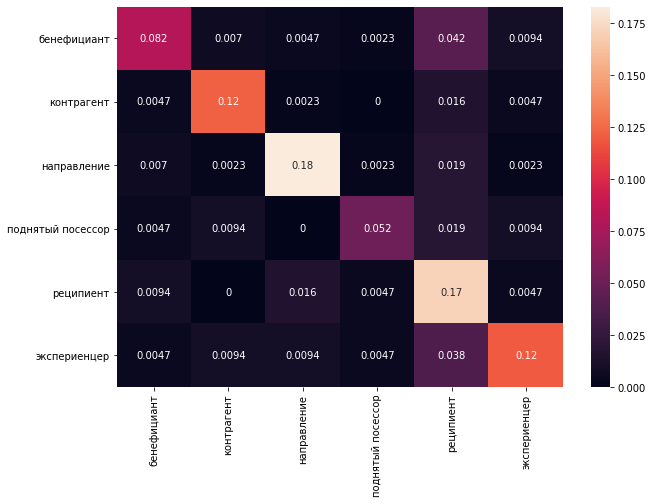

In [9]:
logreg = LogisticRegression()
logreg.fit(X_train_o, y_train_o)
y_pred = logreg.predict(X_test_o)
calculate_metrics(y_test_o, y_pred)

Посмотрим на самые важные признаки логистической регрессии

In [10]:
feas = pd.DataFrame({
    'feature': X_train_o.columns,
    'importance': logreg.coef_[0].tolist()
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
feas.head(15)

,feature,importance
0,v.lemma_вредить,2.543227
1,v.lemma_угрожать,1.930341
2,v.lemma_вырезать,1.298128
3,v.lemma_открыть,1.143431
4,v.lemma_нравиться,1.034547
5,v.r_t:impact,0.920466
6,d.lemma_судьба,0.914140
7,v.lemma_купить,0.827163
8,d.lemma_работник,0.769737
9,d.lemma_мореход,0.754766


## 4. Полносвязная нейронная сеть

Параметры нейросети:

In [11]:
model = nn.Sequential(nn.Linear(X_train_o.shape[1], 1024),
                      nn.BatchNorm1d(1024),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(1024, 64),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 6))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler =  optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [12]:
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()

    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()

    losses = []
    predicted_classes = []
    true_classes = []
    with torch.no_grad():
        for X, y in val_dataloader:
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y.long())

            losses.append(loss)
            predicted_classes.extend(torch.argmax(y_pred, dim=-1).tolist())
            true_classes.extend(y.tolist())
    return losses, predicted_classes, true_classes


def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=50, scheduler=None):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_one_epoch(model, train_dataloader, criterion, optimizer)
        
        losses, pred, target = predict(model, val_dataloader, criterion)
        f1 = f1_score(target, pred, average='weighted')
        scheduler.step(f1)
        if epoch == n_epochs - 1:
            calculate_metrics(target, pred)

Accuracy is 0.744131455399061
Macro F1-score is 0.7418703366841024
Micro F1-score is 0.7441314553990611
Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.57      0.65        63
           1       0.84      0.84      0.84        64
           2       0.88      0.87      0.87        92
           3       0.86      0.60      0.71        40
           4       0.54      0.81      0.65        88
           5       0.81      0.66      0.73        79

    accuracy                           0.74       426
   macro avg       0.78      0.72      0.74       426
weighted avg       0.77      0.74      0.75       426




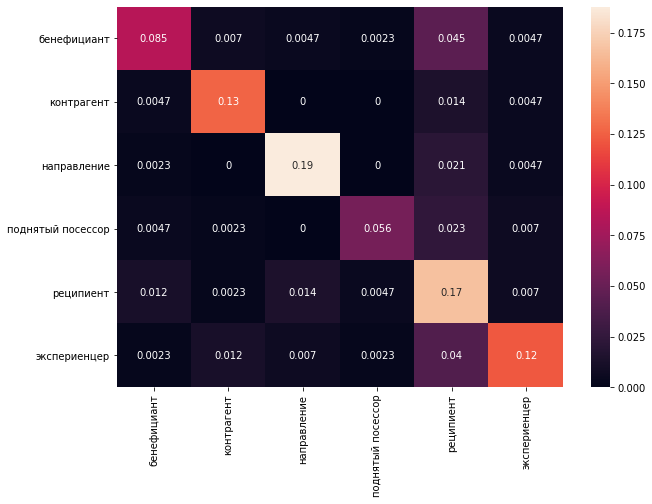

In [13]:
train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=25, scheduler=scheduler)

## 5. Ансамбли деревьев

Случайный лес:

Accuracy is 0.715962441314554
Macro F1-score is 0.695534965635757
Micro F1-score is 0.715962441314554
Classification report: 
               precision    recall  f1-score   support

           0       0.72      0.66      0.68        58
           1       0.77      0.79      0.78        61
           2       0.77      0.88      0.82        90
           3       0.64      0.47      0.54        34
           4       0.68      0.70      0.69       112
           5       0.66      0.65      0.65        71

    accuracy                           0.72       426
   macro avg       0.71      0.69      0.70       426
weighted avg       0.71      0.72      0.71       426



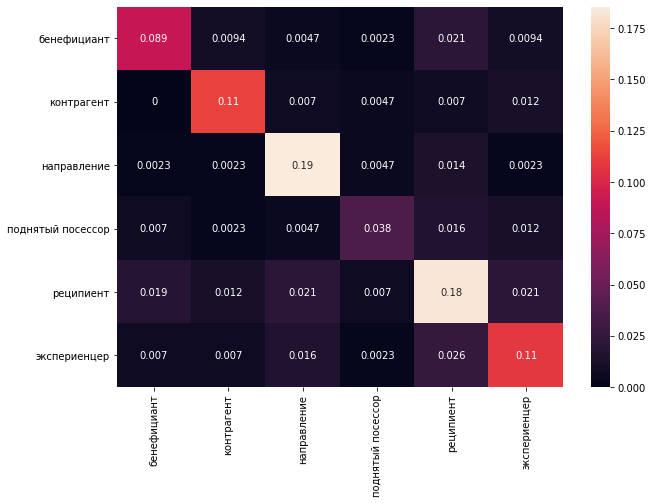

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
calculate_metrics(y_test, y_pred)

Градиентный бустинг:

Accuracy is 0.7276995305164319
Macro F1-score is 0.714796032156436
Micro F1-score is 0.7276995305164319
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.53      0.60        58
           1       0.70      0.84      0.76        61
           2       0.79      0.86      0.82        90
           3       0.78      0.62      0.69        34
           4       0.71      0.71      0.71       112
           5       0.69      0.70      0.70        71

    accuracy                           0.73       426
   macro avg       0.73      0.71      0.71       426
weighted avg       0.73      0.73      0.72       426



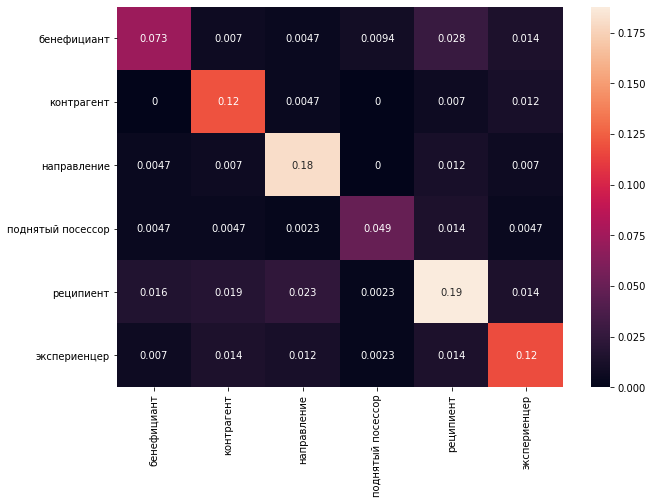

In [15]:
clf_r = xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True)
clf_r.fit(X_train, y_train)
y_pred = clf_r.predict(X_test)
calculate_metrics(y_test, y_pred)

Посмотрим на самые важные признаки для XGBoost-модели:

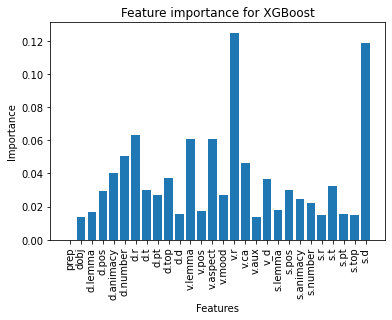

In [16]:
feas = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf_r.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)
plt.bar(X_train.columns, clf_r.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importance for XGBoost')
plt.xticks(rotation=90)
plt.show()